# Imports

In [ ]:
pip install keras-tuner


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os
import random
from kerastuner import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

# Dataset preparation

In [ ]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [ ]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [ ]:
train.isna().sum()

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


In [ ]:
test.isna().sum()

,0
Loan_ID,0
Gender,11
Married,0
Dependents,10
Education,0
Self_Employed,23
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,5
Loan_Amount_Term,6


## Categorical Variables

Gender:
  Since the only two entries other than Nan are Male and Female it is likely that the survey had only two options and some people were inclined to not align themselves with either. Thus the the missing values should be replaced with "Other"

In [ ]:
train['Gender'].fillna(value = 'Other', inplace = True)
test['Gender'].fillna(value = 'Other', inplace = True)

Married: There are 3 rows in the train set with missing "Married" value. Compared to the size of the dataset these are few, and their absence is unlikely to significantly impact the analysis. Thus these values can be dropped

In [ ]:
train = train.dropna(subset=['Married'])

Dependents, Self_employed, Loan_amount_term (could be treated as categorical since the variable is a combination of discrete values like 180 months or 360 months etc): fill the NaN values with the mode (most common value)

In [ ]:
for col in ['Dependents', 'Self_Employed', 'Loan_Amount_Term']:
    mode_value_train = train[col].mode()[0]
    mode_value_test = test[col].mode()[0]
    train[col].fillna(mode_value_train, inplace=True)
    test[col].fillna(mode_value_test, inplace=True)

## Numerical Data

Since it is a dataset of loans given to individuals NaN values in LoanAmount columns should be filled. Similar logic is applied to the Credit History variable. Therefore, imputing NaN with the mode

In [ ]:
credit_history_mode = train['Credit_History'].mode()[0]
train['Credit_History'].fillna(credit_history_mode, inplace=True)
test['Credit_History'].fillna(credit_history_mode, inplace=True)

loan_amount_mode = train['LoanAmount'].mode()[0]
train['LoanAmount'].fillna(loan_amount_mode, inplace=True)
test['LoanAmount'].fillna(loan_amount_mode, inplace=True)

## Encoding Categorical Data

In [ ]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

encoder = OneHotEncoder(sparse_output=False)

encoded_train = encoder.fit_transform(train[categorical_columns])

encoded_test = encoder.transform(test[categorical_columns])

encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns), index=train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns), index=test.index)

train = train.drop(columns=categorical_columns)
test = test.drop(columns=categorical_columns)

train_encoded = pd.concat([train, encoded_train_df], axis=1)
test_encoded = pd.concat([test, encoded_test_df], axis=1)

In [ ]:
train_encoded['Loan_Status'] = train_encoded['Loan_Status'].replace({'Y': 1, 'N': 0})

## Outliers

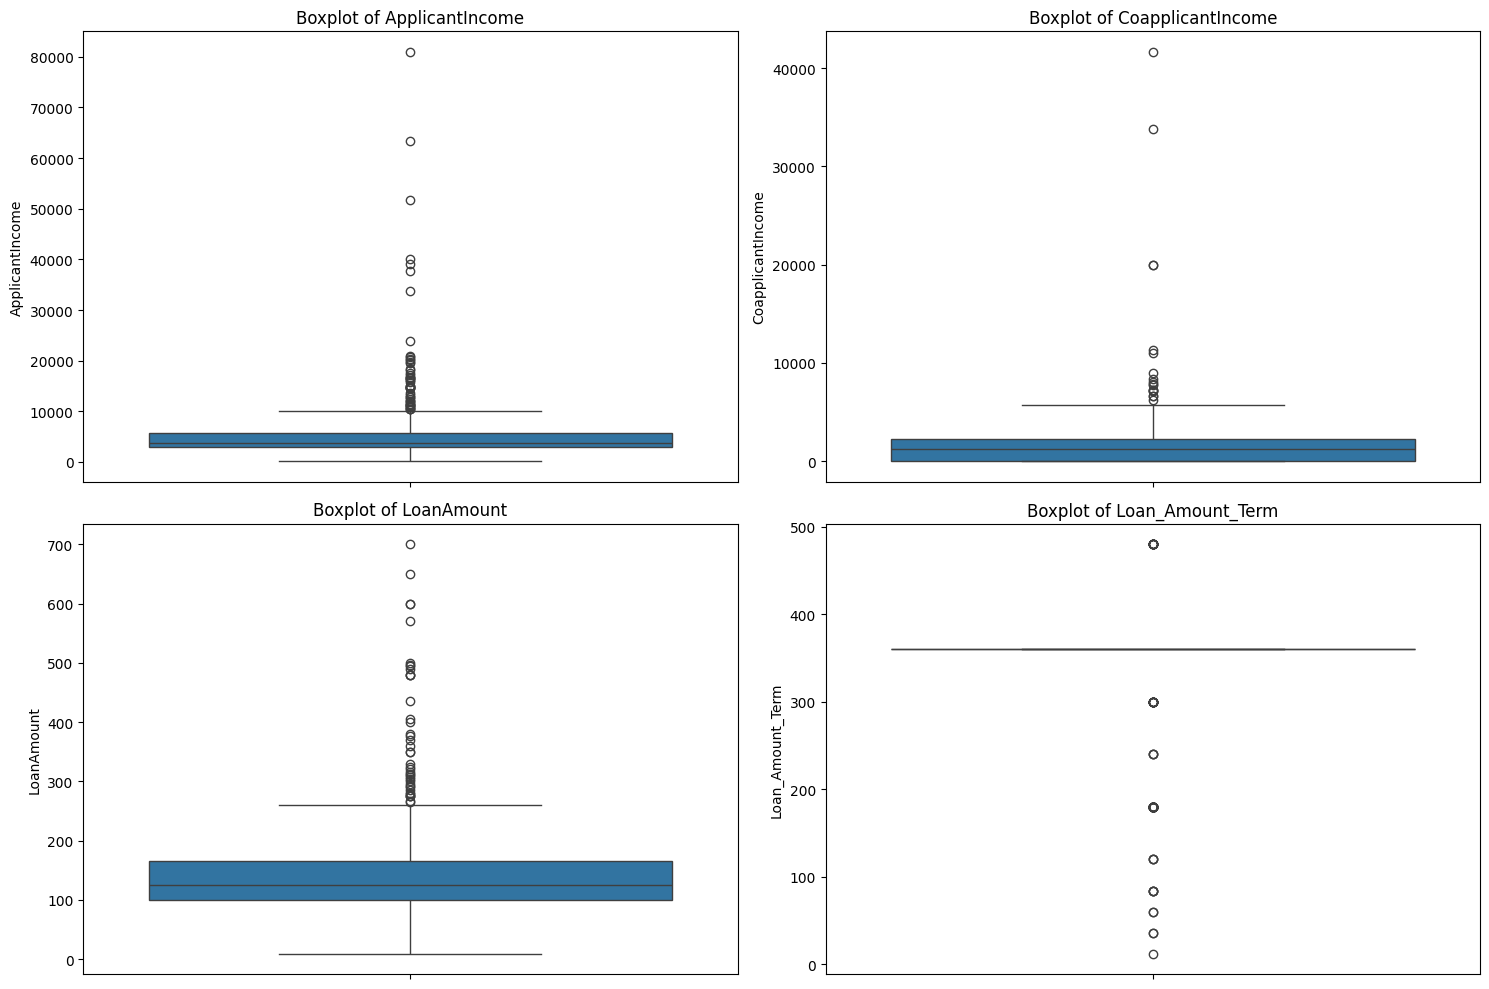

In [ ]:
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=train_encoded[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

## Standardization

In [ ]:
def standardize_column(col):
    mean = col.mean()
    std = col.std()
    return (col - mean) / std

for column in numerical_columns:
    train_encoded[column] = standardize_column(train_encoded[column])
    test_encoded[column] = standardize_column(test_encoded[column])

train_encoded.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Gender_Other,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,0.073436,-0.555291,-0.301776,0.27529,1.0,1,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,LP001003,-0.133401,-0.040922,-0.206964,0.27529,1.0,0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,LP001005,-0.392028,-0.555291,-0.941754,0.27529,1.0,1,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,LP001006,-0.460157,0.249008,-0.301776,0.27529,1.0,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,LP001008,0.098106,-0.555291,-0.052895,0.27529,1.0,1,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
len(train)

611

In [ ]:
y = train_encoded['Loan_Status']
X = train_encoded.drop(columns=['Loan_ID', 'Loan_Status'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (390, 21)
Validation set shape: (98, 21)
Test set shape: (123, 21)


In [ ]:
y_test

,Loan_Status
81,1
219,1
55,1
602,1
266,1
...,...
533,0
532,0
119,1
79,1


# Logistic Regression

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, regularization='l2', lambda_reg=0.01):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.verbose = verbose
        self.losses = []  # To track the loss at each iteration
        self.regularization = regularization  # Regularization type ('l2' or 'l1')
        self.lambda_reg = lambda_reg  # Regularization strength (lambda)

    def logistic(self, z):
        return 1. / (1 + np.exp(-z))

    def compute_loss(self, x, y):
        yh = self.logistic(np.dot(x, self.w))
        # Binary cross-entropy loss
        loss = -np.mean(y * np.log(yh + 1e-15) + (1 - y) * np.log(1 - yh + 1e-15))

        # Add L2 regularization to the loss (exclude bias term)
        if self.regularization == 'l2':
            loss += (self.lambda_reg / 2) * np.sum(np.square(self.w[:-1]))

        return loss

    def gradient(self, x, y):
        N, D = x.shape
        yh = self.logistic(np.dot(x, self.w))  # Predictions size N
        grad = np.dot(x.T, yh - y) / N  # Divide by N because cost is mean over N points

        # Add L2 regularization to the gradient (exclude bias term)
        if self.regularization == 'l2':
            grad[:-1] += self.lambda_reg * self.w[:-1]

        return grad

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # Gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g

            # Track the loss at each iteration
            loss = self.compute_loss(x, y)
            self.losses.append(loss)

            t += 1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'final loss: {self.losses[-1]:.4f}')
            print(f'the weight found: {self.w}')
        return self

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x, np.ones(Nt)])
        yh = self.logistic(np.dot(x, self.w))  # Predict output
        return yh

In [ ]:
log_reg_model = LogisticRegression(learning_rate=0.01, max_iters=10000, verbose=False)

log_reg_model.fit(X_train, y_train)

y_val_pred_proba = log_reg_model.predict(X_val)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

# accuracy of the validation set
accuracy_val = np.mean(y_val_pred == y_val)
print(f'Validation accuracy: {accuracy_val:.4f}')

y_test_pred_proba = log_reg_model.predict(X_test)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# accuracy of the test set
accuracy_test = np.mean(y_test_pred == y_test)
print(f'Test accuracy: {accuracy_test:.4f}')

Validation accuracy: 0.8061
Test accuracy: 0.8293


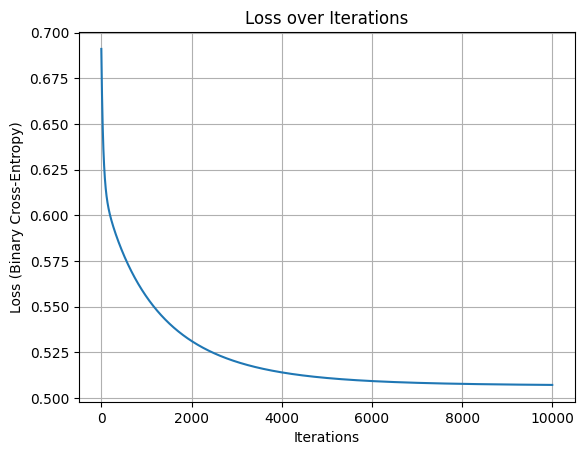

In [ ]:
# Plot the loss over iterations
plt.plot(log_reg_model.losses)
plt.title('Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss (Binary Cross-Entropy)')
plt.grid(True)
plt.show()

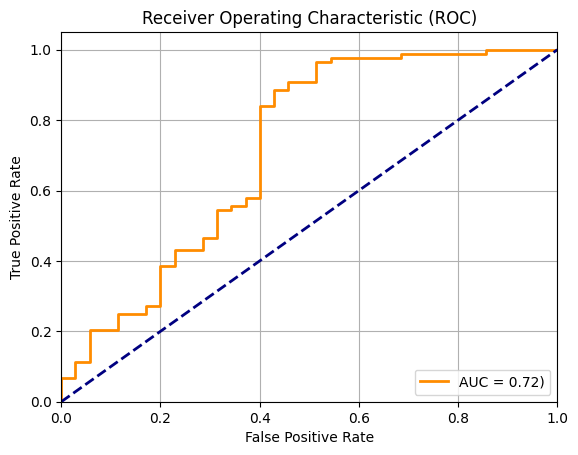

AUC Score: 0.7169


In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f'AUC Score: {roc_auc:.4f}')


# MLP

In [ ]:
# Check the distribution of the target variable (Loan_Status)
print(train_encoded['Loan_Status'].value_counts())

Loan_Status
1    419
0    192
Name: count, dtype: int64


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.6375 - loss: 0.6881 - val_accuracy: 0.6122 - val_loss: 0.6567
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6272 - loss: 0.6822 - val_accuracy: 0.6122 - val_loss: 0.6566
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6052 - loss: 0.6801 - val_accuracy: 0.5918 - val_loss: 0.6577
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6177 - loss: 0.6747 - val_accuracy: 0.5918 - val_loss: 0.6595
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5999 - loss: 0.6628 - val_accuracy: 0.5816 - val_loss: 0.6622
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6062 - loss: 0.6330 - val_accuracy: 0.6020 - val_loss: 0.6575
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6358 - loss: 0.6456 - val_accuracy: 0.6327 - val_loss: 0.6473
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6305 - loss: 0.6506 - val_accuracy: 0.

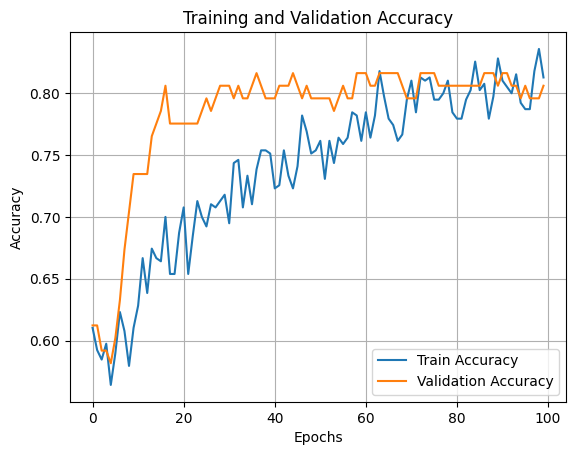

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


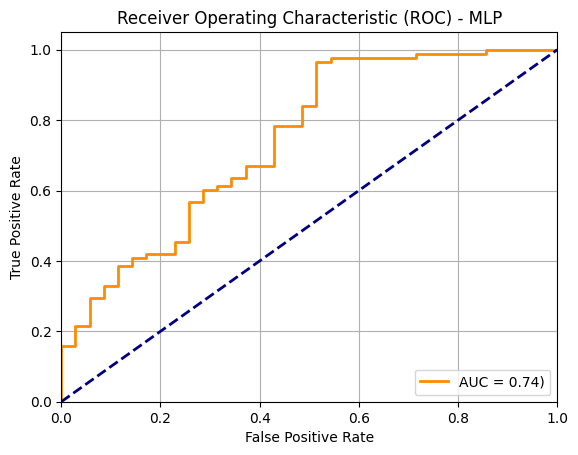

AUC Score for MLP: 0.7438


In [ ]:
import tensorflow as tf
from keras import layers, models, optimizers
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def create_mlp(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

input_shape = X_train.shape[1]


mlp_model = create_mlp(input_shape)

mlp_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights_dict = dict(enumerate(class_weights))

history = mlp_model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=100,
                        batch_size=32,
                        class_weight=class_weights_dict,
                        verbose=1)


test_loss, test_accuracy = mlp_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

y_test_pred_proba_mlp = mlp_model.predict(X_test)
y_test_pred_mlp = (y_test_pred_proba_mlp > 0.5).astype(int)

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_test_pred_proba_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure()
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'AUC = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - MLP')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f'AUC Score for MLP: {roc_auc_mlp:.4f}')
